In [61]:
# standard library
import sys,os
sys.path.append('..')
from pprint import pprint

# data and nlp
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm", disable=["ner"])

# visualisation
import pyLDAvis
pyLDAvis.enable_notebook()
import seaborn as sns
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 20,10


# LDA tools
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from utils import lda_utils

# warnings
import logging, warnings
warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

ModuleNotFoundError: No module named 'pyLDAvis.gensim'

In [27]:
import json

# Unfortunately newlines have been parsed as nothing instead of spaces
# but the script will work just the same
with open('data/all_series_lines.json') as file:
    content = file.read()
    line_dict = json.loads(content)

line_dict['DS9']['episode 0']['ODO']

['Yes, Major?',
 "My security array has been down for two hours. I'llmeet you there.",
 'All right, just stand where you are.',
 'Who the hell are you?',
 "I don't allow weapons on the Promenade. That includes phasers.",
 "The boy's in a lot of trouble.",
 "I'm curious myself. The man is a gambler and a thief.",
 'You are a thief.',
 'Seems reasonable. You have all the character references of apolitician.',
 'And a thief.',
 "You know, at first, I didn't think I was going to like him.",
 "This is a security matter. I'm in charge of security.",
 "Major, I was found in the Denorios Belt. I don't know where I camefrom, no idea if there are any others like me. All my life, I've beenforced to pass myself off as one of you, always wondering who I reallyam. Well, the answers to a lot of my questions may be somewhere on theother side of that wormhole. You coming?",
 "Doctor, most people in my experience wouldn't know reason if itwalked up and shook their hand. You can count Gul Dukat among the

In [30]:
episodes = {}

for series_name, series in line_dict.items():
    for episode_name, episode in series.items():
        episode_string = ''

        for character_lines in episode.values():
            lines = ' '.join(character_lines)
            
            # Avoid adding just spaces
            if len(lines) != 0:
                episode_string += ' ' + lines

        # Add the string containing all lines from the episode to our dict
        episode_key = series_name + '_' + episode_name.split()[1]
        episodes[episode_key] = episode_string

# explicitly convert to a list for processing
episode_lines = list(episodes.values())

In [33]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(episode_lines, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[episode_lines], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [52]:
# Tokenize, remove stopwords etc
processed_lines = lda_utils.process_words(episode_lines, nlp, bigram_mod, trigram_mod, allowed_postags=["NOUN"])

In [53]:
# Convert every token to an id
id2word = corpora.Dictionary(processed_lines)

# Count frequencies of the tokens (ids) collocation within an episode
corpus = [id2word.doc2bow(episode_lines) for episode_lines in processed_lines]

In [54]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=12, 
                                       random_state=420,
                                       chunksize=10,
                                       passes=10,
                                       iterations=100,
                                       per_word_topics=True, 
                                       minimum_probability=0.0)

In [55]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=processed_lines, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.013080887651983

Coherence Score:  0.36863578189366547


In [56]:
pprint(lda_model.print_topics())

[(0,
  '0.000*"verin" + 0.000*"enhancer" + 0.000*"talaxian" + 0.000*"expectation" + '
  '0.000*"icheb" + 0.000*"mechanic" + 0.000*"brax" + 0.000*"infant" + '
  '0.000*"template" + 0.000*"naomi"'),
 (1,
  '0.001*"german" + 0.001*"sal" + 0.000*"augment" + 0.000*"embryo" + '
  '0.000*"briar" + 0.000*"pursuitcourse" + 0.000*"mightdamage" + '
  '0.000*"thecamouflage" + 0.000*"leftearth" + 0.000*"lokesh"'),
 (2,
  '0.000*"heresomewhere" + 0.000*"cyrus" + 0.000*"cyrusramsey" + '
  '0.000*"talkto" + 0.000*"givethem" + 0.000*"morse" + 0.000*"warpimbalance" + '
  '0.000*"beenshaky" + 0.000*"somethingwent" + 0.000*"mymirror"'),
 (3,
  '0.000*"time" + 0.000*"captain" + 0.000*"ship" + 0.000*"year" + '
  '0.000*"prophet" + 0.000*"people" + 0.000*"thing" + 0.000*"hour" + '
  '0.000*"bajor" + 0.000*"life"'),
 (4,
  '0.034*"ship" + 0.024*"captain" + 0.015*"time" + 0.011*"system" + '
  '0.011*"power" + 0.010*"sensor" + 0.010*"crew" + 0.010*"course" + '
  '0.009*"shield" + 0.009*"commander"'),
 (5,
  '0.

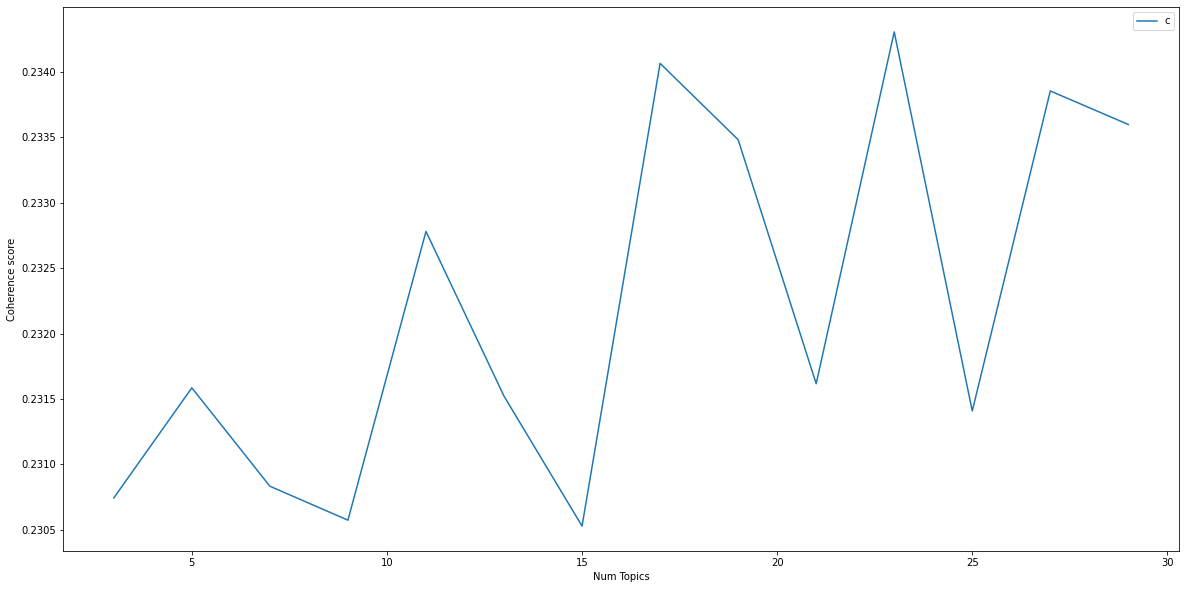

Num Topics = 3  has Coherence Value of 0.2307
Num Topics = 5  has Coherence Value of 0.2316
Num Topics = 7  has Coherence Value of 0.2308
Num Topics = 9  has Coherence Value of 0.2306
Num Topics = 11  has Coherence Value of 0.2328
Num Topics = 13  has Coherence Value of 0.2315
Num Topics = 15  has Coherence Value of 0.2305
Num Topics = 17  has Coherence Value of 0.2341
Num Topics = 19  has Coherence Value of 0.2335
Num Topics = 21  has Coherence Value of 0.2316
Num Topics = 23  has Coherence Value of 0.2343
Num Topics = 25  has Coherence Value of 0.2314
Num Topics = 27  has Coherence Value of 0.2339
Num Topics = 29  has Coherence Value of 0.2336


In [57]:
model_list, coherence_values = lda_utils.compute_coherence_values(texts=processed_lines,
                                                                  corpus=corpus, 
                                                                  dictionary=id2word,  
                                                                  start=3, 
                                                                  limit=30,  
                                                                  step=2)

In [58]:
df_topic_keywords = lda_utils.format_topics_sentences(ldamodel=lda_model, 
                                                      corpus=corpus, 
                                                      texts=processed_lines)

# Format
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.sample(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
187,187,9.0,0.8406,"time, way, day, thing, people, year, friend, s...","[husband, congratulation, reactor, core, home,..."
300,300,10.0,0.6702,"captain, doctor, time, people, life, way, ship...","[prying, captain, request, absence, home, plan..."
179,179,9.0,0.7938,"time, way, day, thing, people, year, friend, s...","[morning, station, element, week, wife, lewdne..."
499,499,10.0,0.6974,"captain, doctor, time, people, life, way, ship...","[transport, screen, injury, course, captain, b..."
40,40,4.0,0.7254,"ship, captain, time, system, power, sensor, cr...","[biosign, idea, launch, history, book, geta, s..."
403,403,10.0,0.7269,"captain, doctor, time, people, life, way, ship...","[doctor, time, officer, course, suchconsuming,..."
646,646,10.0,0.6867,"captain, doctor, time, people, life, way, ship...","[none, crew, relief, week, relayrepair, list, ..."
391,391,4.0,0.5188,"ship, captain, time, system, power, sensor, cr...","[number, mister, data, rice, tell, risk, senso..."
295,295,10.0,0.9605,"captain, doctor, time, people, life, way, ship...","[answer, activity, planet, captain, oddity, si..."
136,136,9.0,0.4287,"time, way, day, thing, people, year, friend, s...","[truth, thebok, truth, discipline, people, ext..."


In [59]:
values = list(lda_model.get_document_topics(corpus))

split = []
for entry in values:
    topic_prevelance = []
    for topic in entry:
        topic_prevelance.append(topic[1])
    split.append(topic_prevelance)

df = pd.DataFrame(map(list,zip(*split)))

sns.lineplot(data=df.T.rolling(50).mean())

AttributeError: module 'pyLDAvis' has no attribute 'gensim'